In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
!pip3 install bert-for-tf2
!pip3 install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 111 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=0147f15ecf3d8eaeb4d99201b95b87aefcf015a01beaff26f6382d7c3b627b09
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=ebc0de56ef204c401b02e6bdab52b93e19f58e07c63c294d310b5194bd88ed55
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=2c99c5e69828f8daa1f6dac7b190587e2aefd072bf21a6e3b03f8db94e9a818f
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow p

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from bert.tokenization.bert_tokenization import FullTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, LSTM

In [ ]:
# Set up the device for GPU usage
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
# connect to google drive for files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pre-processing

In [ ]:
train = pd.read_pickle("/content/drive/MyDrive/DATA-793 Pinyu Chen/train_allfeats_09052022.pkl")

In [ ]:
test = pd.read_pickle("/content/drive/MyDrive/DATA-793 Pinyu Chen/test_allfeats_09052022.pkl")

In [ ]:
test.isnull().sum()

tweet_id                      0
lang                          0
res_image_vectors             0
vgg_image_vectors             0
tweet_text                    0
label                         0
event                         0
new_img_id                    0
clean_tweet                   0
text_feats_1                  0
text_feats_2                  0
pooler                        0
sm_last_four_concat           0
mn_last_four_concat           0
mn_2ndtolast_lyr              0
sm_2ndtolast_lyr              0
num_friends                   0
num_followers                 0
folfriend_ratio               0
times_listed                  0
has_url                       0
is_verified                   0
num_posts                     0
num_words                     0
text_length                   0
contains_questmark            0
num_questmark                 0
contains_exclammark           0
num_exclammark                0
contains_happyemo             0
contains_sademo               0
contains

In [ ]:
train['label'].value_counts()

fake    5129
real    4013
Name: label, dtype: int64

In [ ]:
test['label'].value_counts()

fake    467
real    329
Name: label, dtype: int64

In [ ]:
train.head(3)

,tweet_id,lang,res_image_vectors,vgg_image_vectors,tweet_text,label,event,new_img_id,clean_tweet,cl_len,...,vgg19_img_vectors,Topic20,Topic10,Topic5,caption,capt_feats,Topic200,Topic300,new_ev,event_feat
0,324597532548276224,en,"[tensor(0.0801), tensor(0.4296), tensor(0.8457...","[tensor(0.2593), tensor(4.9064), tensor(2.8281...",Don't need feds to solve the #bostonbombing wh...,fake,boston,boston_fake_03,"[don, need, feds, solve, bostonbombing, 4chan]",58,...,"[tensor(-3.1332), tensor(-0.5148), tensor(-0.3...",10,3,3,a group of people standing in a crowd of people,"[0.15120442708333334, 0.08012898763020833, 0.0...",46,46,[boston],"[-0.51171875, -0.08544921875, -0.060546875, 0...."
1,325145334739267584,en,"[tensor(0.4698), tensor(2.9610), tensor(1.1333...","[tensor(0.1815), tensor(0.5811), tensor(-0.883...",PIC: Comparison of #Boston suspect Sunil Tripa...,fake,boston,boston_fake_23,"[pic, comparison, boston, suspect, sunil, trip...",139,...,"[tensor(-2.0921), tensor(0.7882), tensor(-2.32...",10,3,3,a man is holding a dog in a hand,"[0.09038798014322917, 0.02313232421875, 0.0066...",36,289,[boston],"[-0.51171875, -0.08544921875, -0.060546875, 0...."
2,325152091423248385,en,"[tensor(0.1619), tensor(1.1982), tensor(0.7997...","[tensor(-2.1295), tensor(-3.1864), tensor(-0.8...",I'm not completely convinced that it's this Su...,fake,boston,boston_fake_34,"[completely, convinced, sunil, tripathi, fellow]",58,...,"[tensor(-1.8948), tensor(0.4038), tensor(-0.76...",10,3,3,a man and a woman wearing a hat and a tie,"[0.077001953125, -0.010888671875, -0.069873046...",114,289,[boston],"[-0.51171875, -0.08544921875, -0.060546875, 0...."


In [ ]:
Text_train = train.iloc[:, 4:9]
Text_test = test.iloc[:, 4:9]

In [ ]:
print(Text_train['label'].value_counts())
print(Text_test['label'].value_counts())

fake    5129
real    4013
Name: label, dtype: int64
fake    467
real    329
Name: label, dtype: int64


In [ ]:
Text_train.head(3)

,tweet_text,label,event,new_img_id,clean_tweet
0,Don't need feds to solve the #bostonbombing wh...,fake,boston,boston_fake_03,"[don, need, feds, solve, bostonbombing, 4chan]"
1,PIC: Comparison of #Boston suspect Sunil Tripa...,fake,boston,boston_fake_23,"[pic, comparison, boston, suspect, sunil, trip..."
2,I'm not completely convinced that it's this Su...,fake,boston,boston_fake_34,"[completely, convinced, sunil, tripathi, fellow]"


In [ ]:
# convert to 1 and 0
Text_train['label'] = np.where(Text_train['label'] == "fake", 1, 0)
Text_test['label'] = np.where(Text_test['label'] == "fake", 1, 0)

In [ ]:
Text_test.head(3)

,tweet_text,label,event,new_img_id,clean_tweet
0,Fuji created huge lenticular clouds and they w...,0,fuji_lenticular,fuji_lenticular_2,"[fuji, created, huge, lenticular, clouds, pain..."
1,"Ever Wonder, If Laura Bush Was All About Liter...",1,bush_book,bush_book_1,"[ever, wonder, laura, bush, was, all, about, l..."
2,Very rare pic of mahatma gandhi n queen elizab...,1,gandhi_dancing,gandhi_dancing_1,"[very, rare, pic, mahatma, gandhi, queen, eliz..."


In [ ]:
Text_train['clean_tweet'] = Text_train['clean_tweet'].astype(pd.StringDtype())
Text_test['clean_tweet'] = Text_test['clean_tweet'].astype(pd.StringDtype())

In [ ]:
y_train = Text_train.label
y_test = Text_test.label

# Load Pre-trained Model

In [ ]:
!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 182 kB 63.8 MB/s 
     |████████████████████████████████| 7.6 MB 42.3 MB/s 


In [ ]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=Text_train.clean_tweet.tolist(),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding="max_length", 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True
    #verbose = True
    )
x_test = tokenizer(
    text=Text_test.clean_tweet.tolist(),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding="max_length", 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True
    #verbose = True
    )

In [ ]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']
segment_ids = x_train["token_type_ids"]

In [ ]:
x_train['input_ids'].shape

TensorShape([9142, 128])

In [ ]:
y_train.shape

(9142,)

# Bert model with GlobalMaxPool1D

In [ ]:
max_len = 128
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
#out = Dense(128, activation='relu')(out)
#out = tf.keras.layers.Dropout(0.1)(out)
#out = Dense(32,activation = 'relu')(out)
y = Dense(1,activation = 'sigmoid')(out)
model1 = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model1.layers[2].trainable = True

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

# Bert model with LSTM (SELU activation and lecun_normal and alpha dropout)

In [ ]:
from functools import partial
# layer = tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
#                            kernel_constraint=tf.keras.constraints.max_norm(1.))
MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

In [ ]:
max_len = 128
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_ids, input_mask, segment_ids])
lstm_out = tf.keras.layers.Bidirectional(LSTM(128, name='LSTM'))(sequence_output)
# out = tf.keras.layers.Dense(128, activation="selu",kernel_initializer="lecun_normal")(lstm_out)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = MaxNormDense(128)(lstm_out)
# out = tf.keras.layers.AlphaDropout(rate=0.5)(out)
# out = MaxNormDense(64)(out)
# out = tf.keras.layers.AlphaDropout(rate=0.5)(out)
# out = MaxNormDense(32)(out)
# out = tf.keras.layers.AlphaDropout(rate=0.5)(out)
# out = Dense(16,activation = 'relu')(out)
# out = tf.keras.layers.Dropout(0.1)(out)
y = Dense(1,activation = 'sigmoid')(out)
model2 = tf.keras.Model(inputs=[input_ids, input_mask, segment_ids], outputs=y)
model2.layers[2].trainable = True

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 128, 768)]                'attention_mask[0][0]',   

# Bert model (SELU activation and lecun_normal and alpha dropout) + LSTM with CNN

In [ ]:
max_length = 128

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)


def build_model(bert_layer, max_len=128):
    '''
    Function to build a tensorflow machine learning neural network model.
    
    :param: bert_layer - the loaded BERT layer from TF hub
    :param: max_len - the maximum length of an input sequence for encoding purposes, used here to denote the input shape
    
    :output: Model - Tensorflow keras model with inputs and outputs designated
    '''
    # INPUTS
    input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="segment_ids")
    
    # BERT EMBEDDING
    _, sequence_output = bert_layer([input_word_ids,input_mask,segment_ids])
    clf_output = sequence_output[:, 0, :]
    clf_output_ = tf.keras.layers.Reshape((32,24))(clf_output)
    
    # HIDDEN
    hidden = tf.keras.layers.Dense(128,activation='relu')(clf_output)
    out = MaxNormDense(128)(hidden)
    # out = tf.keras.layers.AlphaDropout(rate=0.2)(out)
    # out = MaxNormDense(64)(out)
    # out = tf.keras.layers.AlphaDropout(rate=0.2)(out)
    # out = MaxNormDense(32)(out)
    # out = tf.keras.layers.AlphaDropout(rate=0.2)(out)
    # out = Dense(16,activation = 'relu')(out)
    drop = tf.keras.layers.AlphaDropout(0.1)(out)
    
    # CHANNEL 2 - LSTM
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,
                                kernel_regularizer=tf.keras.regularizers.L2(0.001),
                                                             return_sequences=True))(clf_output_)
    drop2 = tf.keras.layers.Dropout(0.1)(lstm)
    cnn = tf.keras.layers.Conv1D(64,5, kernel_regularizer=tf.keras.regularizers.L2(0.001))(drop2)
    max_pool = tf.keras.layers.MaxPooling1D(25)(cnn)
    flat = tf.keras.layers.Flatten(data_format='channels_last')(max_pool)
    
    # OUTPUTS
    concat = tf.keras.layers.Concatenate()([drop,flat])
    output_target = tf.keras.layers.Dense(1,activation='sigmoid')(concat)
    
    return tf.keras.Model(inputs=[input_word_ids,input_mask,segment_ids],outputs=output_target)

In [ ]:
model3 = build_model(bert_layer,max_len=128)
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 128, 768)]                'attention_mask[0][0]',   

# Model compile and training

In [ ]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
n_epochs = 10

In [ ]:
model2.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model3.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping and model saving

In [ ]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint('model_tweet_text.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [ ]:
# Save and Load model
checkpoint_filepath = '/content/drive/MyDrive/DATA-793 Pinyu Chen/model_tweet_text1.h5'
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

checkpoint_filepath = '/content/drive/MyDrive/DATA-793 Pinyu Chen/model_tweet_text2.h5'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

checkpoint_filepath = '/content/drive/MyDrive/DATA-793 Pinyu Chen/model_tweet_text3.h5'
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Exponential Scheduling

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 12.5)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=12.5)

In [ ]:
# callbacks=[lr_scheduler]
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Piecewise Constant Scheduling

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 3:
        return 0.01
    elif epoch < 6:
        return 0.005
    else:
        return 0.001

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([3, 6], [0.01, 0.005, 0.001])

In [ ]:
# callbacks=[lr_scheduler]
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

# Training model 1

In [ ]:
train_history = model1.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
    epochs=n_epochs,
    callbacks=[earlystopping, model_checkpoint_callback1, lr_scheduler],
    # batch_size=32
)

Epoch 1/10


286/286 [==============================] - 257s 835ms/step - loss: 0.7399 - accuracy: 0.5249 - val_loss: 0.7052 - val_accuracy: 0.4133 - lr: 0.0100
Epoch 2/10
286/286 [==============================] - 235s 823ms/step - loss: 0.6870 - accuracy: 0.5610 - val_loss: 0.7028 - val_accuracy: 0.4133 - lr: 0.0083
Epoch 3/10
286/286 [==============================] - 239s 837ms/step - loss: 0.6866 - accuracy: 0.5610 - val_loss: 0.6869 - val_accuracy: 0.5867 - lr: 0.0069
Epoch 4/10
286/286 [==============================] - 235s 823ms/step - loss: 0.6863 - accuracy: 0.5610 - val_loss: 0.6836 - val_accuracy: 0.5867 - lr: 0.0058
Epoch 5/10
286/286 [==============================] - 235s 822ms/step - loss: 0.6860 - accuracy: 0.5610 - val_loss: 0.6793 - val_accuracy: 0.5867 - lr: 0.0048
Epoch 6/10
286/286 [==============================] - 235s 822ms/step - loss: 0.6859 - accuracy: 0.5610 - val_loss: 0.6792 - val_accuracy: 0.5867 - lr: 0.0040
Epoch 7/10
286/286 [==============================] - 235

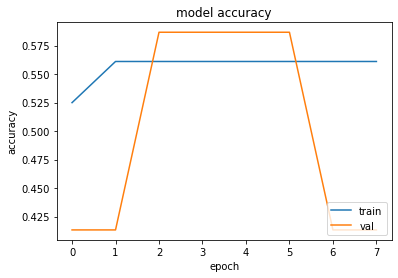

In [ ]:
# plot accuracy
import matplotlib.pyplot as plt
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

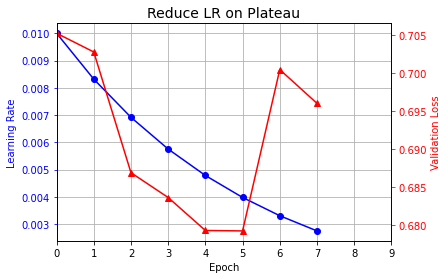

In [ ]:
plt.plot(train_history.epoch, train_history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(train_history.epoch, train_history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

# Training model 2

In [ ]:
# batch_size=32
# step_size_train=x_train['input_ids'].shape[0]//batch_size
# step_size_valid=x_test['input_ids'].shape[0]//batch_size

train_history2 = model2.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask'], 'segment_ids':x_train["token_type_ids"]} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask'], 'segment_ids':x_test["token_type_ids"]}, y_test
    ),
    epochs=n_epochs,
    # validation_steps=step_size_valid,
    callbacks=[earlystopping, model_checkpoint_callback2, lr_scheduler],
    verbose=1
    # batch_size=32
)

Epoch 1/10
286/286 [==============================] - 268s 937ms/step - loss: 0.6910 - accuracy: 0.5516 - val_loss: 0.6794 - val_accuracy: 0.5867 - lr: 0.0100
Epoch 2/10
286/286 [==============================] - 251s 878ms/step - loss: 0.6888 - accuracy: 0.5476 - val_loss: 0.7284 - val_accuracy: 0.5867 - lr: 0.0083
Epoch 3/10
286/286 [==============================] - 251s 878ms/step - loss: 0.6882 - accuracy: 0.5581 - val_loss: 0.6814 - val_accuracy: 0.5867 - lr: 0.0069
Epoch 3: early stopping


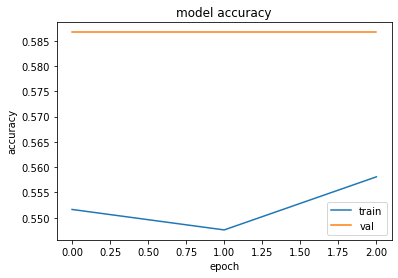

In [ ]:
# plot accuracy
plt.plot(train_history2.history['accuracy'])
plt.plot(train_history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

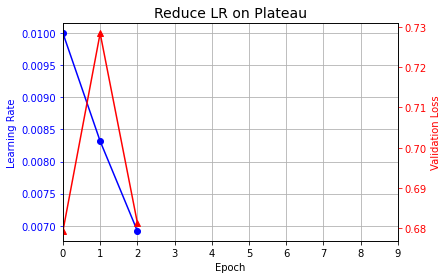

In [ ]:
plt.plot(train_history2.epoch, train_history2.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(train_history2.epoch, train_history2.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

# Training mode 3

In [ ]:
# batch_size=32
# step_size_train=x_train['input_ids'].shape[0]//batch_size
# step_size_valid=x_test['input_ids'].shape[0]//batch_size

train_history3 = model3.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask'], 'segment_ids':x_train["token_type_ids"]} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask'], 'segment_ids':x_test["token_type_ids"]}, y_test
    ),
    epochs=n_epochs,
    # validation_steps=step_size_valid,
    callbacks=[earlystopping, model_checkpoint_callback2, lr_scheduler],
    verbose=1
    # batch_size=32
)

Epoch 1/10
286/286 [==============================] - 280s 862ms/step - loss: 0.8229 - accuracy: 0.5380 - val_loss: 0.6808 - val_accuracy: 0.5867 - lr: 0.0100
Epoch 2/10
286/286 [==============================] - 239s 837ms/step - loss: 0.6925 - accuracy: 0.5443 - val_loss: 0.6807 - val_accuracy: 0.5867 - lr: 0.0083
Epoch 3/10
286/286 [==============================] - 239s 837ms/step - loss: 0.6923 - accuracy: 0.5422 - val_loss: 0.6781 - val_accuracy: 0.5867 - lr: 0.0069
Epoch 4/10
286/286 [==============================] - 239s 837ms/step - loss: 0.6901 - accuracy: 0.5426 - val_loss: 0.6788 - val_accuracy: 0.5867 - lr: 0.0058
Epoch 5/10
286/286 [==============================] - 239s 835ms/step - loss: 0.6916 - accuracy: 0.5418 - val_loss: 0.6809 - val_accuracy: 0.5867 - lr: 0.0048
Epoch 5: early stopping


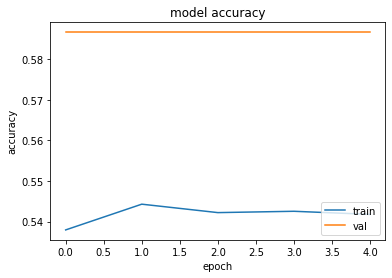

In [ ]:
# plot accuracy
plt.plot(train_history3.history['accuracy'])
plt.plot(train_history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

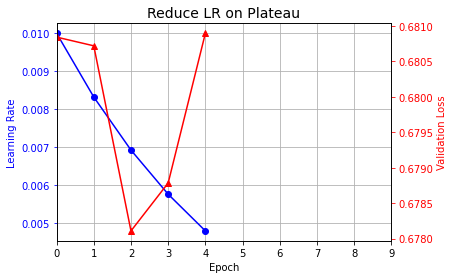

In [ ]:
plt.plot(train_history3.epoch, train_history3.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(train_history3.epoch, train_history3.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

# SGD

In [ ]:
from keras.optimizers import SGD

epochs = 10
learning_rate = 0.1 # initial learning rate
decay_rate = 0.1
momentum = 0.8

# define the optimizer function
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.compile(optimizer=sgd, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

In [ ]:
from keras.callbacks import LearningRateScheduler

lr_rate = LearningRateScheduler(exp_decay)

In [ ]:
batch_size=32
step_size_train=x_train['input_ids'].shape[0]//batch_size
step_size_valid=x_test['input_ids'].shape[0]//batch_size

train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
    epochs=10,
    validation_steps=step_size_valid,
    callbacks=[earlystopping, model_checkpoint_callback, lr_rate],
    verbose=1
    # batch_size=32
)

Epoch 1/10


286/286 [==============================] - 265s 824ms/step - loss: 0.8275 - accuracy: 0.5394 - val_loss: 2.1081 - val_accuracy: 0.5867 - lr: 0.1000
Epoch 2/10
286/286 [==============================] - 234s 818ms/step - loss: 0.6900 - accuracy: 0.5522 - val_loss: 2.1386 - val_accuracy: 0.5867 - lr: 0.0905
Epoch 2: early stopping


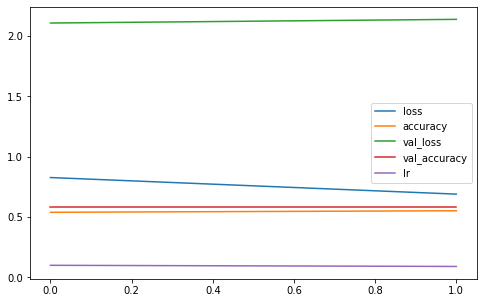

In [ ]:
import matplotlib.pyplot as plt

pd.DataFrame(train_history.history).plot(figsize=(8,5))
plt.show()

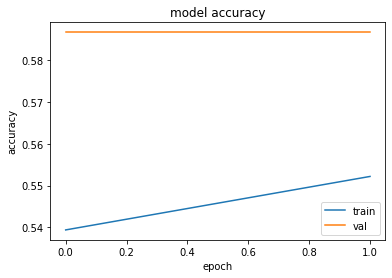

In [ ]:
# plot accuracy
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

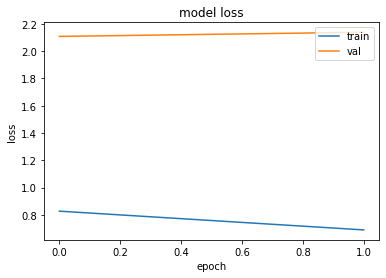

In [ ]:
# plot loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

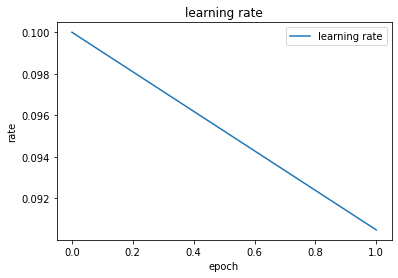

In [ ]:
# plot loss
plt.plot(train_history.history['lr'])
plt.title('learning rate')
plt.ylabel('rate')
plt.xlabel('epoch')
plt.legend(['learning rate'], loc='upper right')
plt.show()